In [ ]:
from google.colab import drive
import os
drive.mount('/content/gdrive/')
os.chdir("/content/gdrive/MyDrive/DISSERTATION")
print(os.listdir())

Mounted at /content/gdrive/
['Diss3.ipynb', 'simple_hilbert.py', 'advection_block.py', '__pycache__', 'Flowpast', 'animation.mp4', 'MeshCNN', 'fpc.obj', 'cache', 'fpc_000.npz', 'fpc.edges', 'fpc_000.npz (Unzipped Files)', 'Advection_of_a_block_over_structured_mesh.ipynb', 'adobe.obj', 'fpc2.obj', 'Diss.ipynb', 'csv_data', 'fpc3.obj', 'animation2.mp4', 'TENS', 'CAE_on_structured_mesh.ipynb', 'Diss2.ipynb', 'AE with FC.ipynb']


In [ ]:
#Importing a bunch of stuff from MeshCNN
os.chdir("./MeshCNN")
import models
import options.train_options
os.chdir("./models")
import networks
os.chdir("./layers")
import mesh
import mesh_pool
os.chdir("../../../")

In [ ]:
#Importing a bunch more libraries
import numpy as np
import matplotlib.pyplot as plt
import torch  # Pytorch
import torch.nn as nn  # Neural network module
import torch.nn.functional as fn  # Function module
from torchvision import datasets  # Datasets from torchvision
from torchvision import transforms  # Transforms from torchvision
from torch.utils.data import DataLoader
from matplotlib import animation
import sys
import progressbar

In [ ]:
!pip install pycm livelossplot
%pylab inline
from livelossplot import PlotLosses

     |████████████████████████████████| 71kB 4.9MB/s 
     |████████████████████████████████| 573kB 26.8MB/s 
Populating the interactive namespace from numpy and matplotlib


In [ ]:
import random 
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = True  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = True

    return True

device = 'cuda'  # Set out device to GPU

print('Cuda installed, running on GPU!')  # print sentence

Cuda installed, running on GPU!


In [ ]:
#Opt class from MeshCNN, to create a "Mesh" class you need an option class for data augmentation purposes, hard to get mesh loading to work otherwise
class opt:
  num_aug = 1

In [ ]:
#Creating my flow past cylinder mesh
fpcmesh = mesh.Mesh("fpc3.obj",opt=opt)
fpcmesh.init_history()

In [ ]:
encdek = networks.MeshEncoderDecoder([10421,8000,6000,4000,3000,2000],[2,2,2,2,2,2,2],[2,2,2,2,2,2,2],transfer_data = True)

In [ ]:
500-128-32-128-500

In [ ]:
encdek

MeshEncoderDecoder(
  (encoder): MeshEncoder(
    (convs): ModuleList(
      (0): DownConv(
        (conv1): MeshConv(
          (conv): Conv2d(2, 2, kernel_size=(1, 5), stride=(1, 1))
        )
        (bn): ModuleList(
          (0): InstanceNorm2d(2, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        )
        (pool): MeshPool()
      )
      (1): DownConv(
        (conv1): MeshConv(
          (conv): Conv2d(2, 2, kernel_size=(1, 5), stride=(1, 1))
        )
        (bn): ModuleList(
          (0): InstanceNorm2d(2, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        )
        (pool): MeshPool()
      )
      (2): DownConv(
        (conv1): MeshConv(
          (conv): Conv2d(2, 2, kernel_size=(1, 5), stride=(1, 1))
        )
        (bn): ModuleList(
          (0): InstanceNorm2d(2, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        )
        (pool): MeshPool()
      )
      (3): DownConv(
        (conv1): MeshConv(

In [ ]:
def loadfpc(index):
  vels = open("./csv_data/data_"+ str(index) + ".csv")
  velocities = np.loadtxt(vels, delimiter=",")[:,3:5]
  EdgeFeatures = np.array([[(velocities[edge[0]][0]+velocities[edge[1]][0])/2,(velocities[edge[0]][1]+velocities[edge[1]][1])/2] for edge in fpcmesh.edges])
  velx = torch.Tensor([[EdgeFeatures[:,0],EdgeFeatures[:,1]]])
  return velx

In [ ]:
def index_split(train_ratio, valid_ratio, test_ratio, total_num = 300):
    if train_ratio + valid_ratio + test_ratio != 1:
        raise ValueError("Three input ratio should sum to be 1!")
    total_index = np.arange(1, total_num)
    rng = np.random.default_rng()
    total_index = rng.permutation(total_index)
    knot_1 = int(total_num * train_ratio)
    knot_2 = int(total_num * valid_ratio) + knot_1
    train_index, valid_index, test_index = np.split(total_index, [knot_1, knot_2])
    return train_index, valid_index, test_index

In [ ]:
def load_tensor(simulation_indexes):
    total = len(simulation_indexes)
    cnt_progress = 0
    bar=progressbar.ProgressBar(maxval=total)
    tensor = loadfpc(0)
    cnt_progress+=1
    bar.update(cnt_progress)    
    for i in range(1, total):
        tensor = torch.cat((tensor, loadfpc(i)))
        cnt_progress+=1
        bar.update(cnt_progress)
    bar.finish()
    return tensor

In [ ]:
train_ratio = 0.8
valid_ratio = 0.1
test_ratio = 0.1
train_index, valid_index, test_index = index_split(train_ratio, valid_ratio, test_ratio, total_num = 1000)

In [ ]:
train_set = load_tensor(train_index)
valid_set = load_tensor(valid_index)
test_set = load_tensor(test_index)

  0% (3 of 800) |                        | Elapsed Time: 0:00:00 ETA:   0:04:18

KeyboardInterrupt: ignored

In [ ]:
torch.save(train_set, './TENS/train_tensor.pt')
torch.save(valid_set, './TENS/valid_tensor.pt')
torch.save(test_set, './TENS/test_tensor.pt')

In [ ]:
train_set = torch.load('./TENS/train_tensor.pt', map_location=torch.device('cpu'))
valid_set = torch.load('./TENS/valid_tensor.pt', map_location=torch.device('cpu'))
test_set = torch.load('./TENS/test_tensor.pt', map_location=torch.device('cpu'))

In [ ]:
print(train_set.size())

torch.Size([800, 2, 10421])


In [ ]:
def train(autoencoder, optimizer, criterion, dataloader):
  counter = 0
  autoencoder.train()
  train_loss, data_length = 0, len(dataloader.dataset)
  for batch in dataloader:
      counter +=1
      meshes = []
      for i in range(dataloader.batch_size):
        fpcmesh = mesh.Mesh("fpc3.obj",opt=opt)
        fpcmesh.init_history()
        meshes.append(fpcmesh)
      # fpcmesh = mesh.Mesh("fpc3.obj",opt=opt)
      # fpcmesh.init_history()
      batch = batch.to(device)  # Send batch of images to the GPU
      optimizer.zero_grad()  # Set optimiser grad to 0
      x_hat = autoencoder(batch,meshes)  # Generate predicted images (x_hat) by running batch of images through autoencoder
      # print("hello")
      # print(batch.size(),x_hat.size())
      MSE = criterion(batch, x_hat)  # Calculate MSE loss
      print(MSE,counter)
      MSE.backward()  # Back-propagate
      optimizer.step()  # Step the optimiser
      train_loss += MSE * batch.size(0)

  return train_loss / data_length  # Return MSE

def validate(autoencoder, optimizer, criterion, dataloader):
    autoencoder.eval()
    validation_loss, data_length = 0, len(dataloader.dataset)
    for batch in dataloader:
        with torch.no_grad():
            meshes = []
            for i in range(dataloader.batch_size):
              fpcmesh = mesh.Mesh("fpc3.obj",opt=opt)
              fpcmesh.init_history()
              meshes.append(fpcmesh)
            batch = batch.to(device)  # Send batch of images to the GPU
            x_hat = autoencoder(batch,meshes)  # Generate predicted images (x_hat) by running batch of images through autoencoder
            MSE = criterion(batch, x_hat)  # Calculate MSE loss
            validation_loss += MSE * batch.size(0)

    return validation_loss / data_length   # Return MSE

In [ ]:
def train_model(autoencoder, batch_size=4, n_epochs = 10, visualize=True):
  set_seed(42)
  autoencoder = autoencoder.to(device)
  optimizer = torch.optim.Adam(autoencoder.parameters())

  # we choose the MSE to be the loss function 
  criterion = nn.MSELoss()

  train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
  valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0)
  
  # do livelossplot if visualize turned-on
  if visualize:
      liveloss = PlotLosses()

  for epoch in range(n_epochs):
    train_MSE = train(autoencoder, optimizer, criterion, train_loader)
    validation_MSE = validate(autoencoder, optimizer, criterion, valid_loader)
    print("eppoch %d starting......"%(epoch))
    
    # do livelossplot if visualize turned-on 
    if visualize: 
      logs = {}

      logs['' + 'log loss'] = train_MSE.item()
      logs['val_' + 'log loss'] = validation_MSE.item()

      liveloss.update(logs)
      liveloss.draw()

      
  return autoencoder

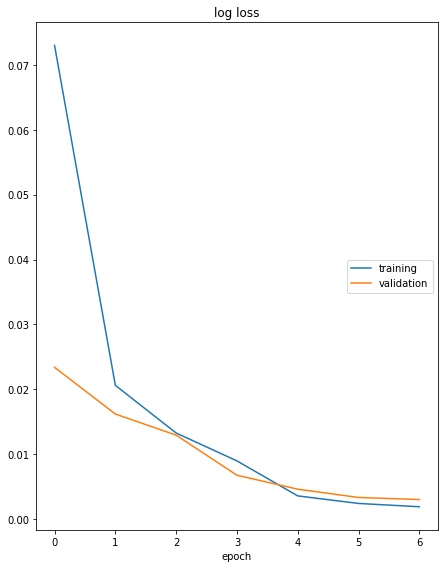

log loss
	training         	 (min:    0.002, max:    0.073, cur:    0.002)
	validation       	 (min:    0.003, max:    0.023, cur:    0.003)
tensor(0.0016, device='cuda:0', grad_fn=<MseLossBackward>) 1
tensor(0.0013, device='cuda:0', grad_fn=<MseLossBackward>) 2
tensor(0.0017, device='cuda:0', grad_fn=<MseLossBackward>) 3
tensor(0.0014, device='cuda:0', grad_fn=<MseLossBackward>) 4
tensor(0.0017, device='cuda:0', grad_fn=<MseLossBackward>) 5
tensor(0.0015, device='cuda:0', grad_fn=<MseLossBackward>) 6
tensor(0.0014, device='cuda:0', grad_fn=<MseLossBackward>) 7
tensor(0.0015, device='cuda:0', grad_fn=<MseLossBackward>) 8
tensor(0.0015, device='cuda:0', grad_fn=<MseLossBackward>) 9
tensor(0.0014, device='cuda:0', grad_fn=<MseLossBackward>) 10
tensor(0.0015, device='cuda:0', grad_fn=<MseLossBackward>) 11
tensor(0.0014, device='cuda:0', grad_fn=<MseLossBackward>) 12
tensor(0.0016, device='cuda:0', grad_fn=<MseLossBackward>) 13
tensor(0.0013, device='cuda:0', grad_fn=<MseLossBackward>) 14


In [ ]:
autoencoder = train_model(encdek)